# Plots for logistic regression, consistent vs inconsistent noiseless AT, increasing epsilon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio

import typing
import os
import shutil
import sys
import warnings

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPORT_DIR_NAME = 'eps_increase_separate_legend'
EXPERIMENT_NAME = 'logistic_regression_inconsistent_consistent_increase_epsilon'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.75, 1.4)
LEGEND_FIGURE_SIZE = (2.75, 0.7)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPORT_DIR_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(
    experiment.experiment_id
)
runs = runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
runs['params.data_dim'] = runs['params.data_dim'].astype(int)
runs['params.data_num_train_samples'] = runs['params.data_num_train_samples'].astype(int)
runs['params.train_attack_epsilon'] = runs['params.train_attack_epsilon'].astype(np.float)
runs['params.test_attack_epsilon'] = runs['params.test_attack_epsilon'].astype(np.float)
runs['params.l2_lambda'] = runs['params.l2_lambda'].astype(np.float)
runs['params.label_noise'] = runs['params.label_noise'].astype(np.float)
runs['metrics.train_robust_risk'] = 1.0 - runs['metrics.train_robust_accuracy']
assert runs['params.l2_lambda'].eq(0).all()
runs['metrics.train_robust_log_loss'] = runs['metrics.training_loss']
runs = runs.sort_values(['params.label_noise'], ascending=True)
print('Loaded', len(runs), 'runs')
assert runs['status'].eq('FINISHED').all()
assert runs['params.label_noise'].eq(0).all()

Loaded 140 runs


In [8]:
grouping_keys = ['params.data_dim', 'params.l2_lambda', 'params.train_consistent_attacks', 'params.train_attack_epsilon', 'params.data_num_train_samples']
aggregate_metrics = ('metrics.true_robust_risk', 'metrics.train_robust_log_loss')
runs_agg = runs.groupby(grouping_keys, as_index=False).aggregate({metric: ['mean', 'std'] for metric in aggregate_metrics})

## Plots

In [9]:
robust_consistent_color_idx = 1
robust_inconsistent_color_idx = 2
population_linestyle = ir.plots.LINESTYLE_MAP[0]
training_linestyle = ir.plots.LINESTYLE_MAP[2]

BASELINE_LAMBDA = 0

In [10]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

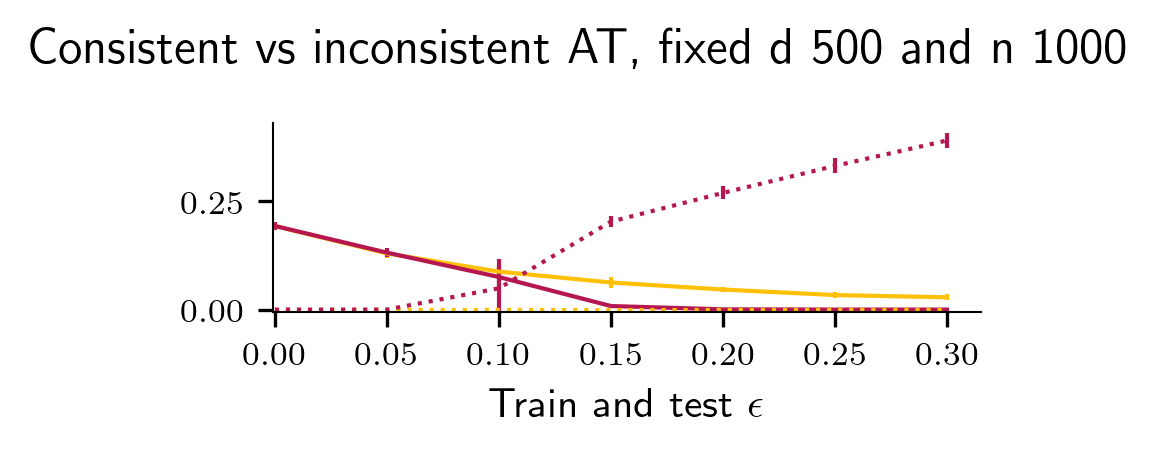

In [11]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

target_num_samples = 1000

current_runs = runs_agg[runs_agg['params.data_num_train_samples'] == target_num_samples]
assert current_runs['params.l2_lambda'].eq(0).all()

data_dim, = current_runs['params.data_dim'].unique()

current_consistent_runs = current_runs[current_runs['params.train_consistent_attacks'] == 'True']
current_inconsistent_runs = current_runs[current_runs['params.train_consistent_attacks'] == 'False']

ax.errorbar(
    current_consistent_runs['params.train_attack_epsilon'],
    current_consistent_runs[('metrics.true_robust_risk', 'mean')],
    yerr=current_consistent_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Robust risk, cons.',
    c=f'C{robust_consistent_color_idx}',
    ls=population_linestyle,
    zorder=2
)
ax.errorbar(
    current_inconsistent_runs['params.train_attack_epsilon'],
    current_inconsistent_runs[('metrics.true_robust_risk', 'mean')],
    yerr=current_inconsistent_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Robust risk, incons.',
    c=f'C{robust_inconsistent_color_idx}',
    ls=population_linestyle,
    zorder=2
)
ax.errorbar(
    current_consistent_runs['params.train_attack_epsilon'],
    current_consistent_runs[('metrics.train_robust_log_loss', 'mean')],
    yerr=current_consistent_runs[('metrics.train_robust_log_loss', 'std')],
    label=fr'Training loss, cons.',
    c=f'C{robust_consistent_color_idx}',
    ls=training_linestyle,
    zorder=2
)
ax.errorbar(
    current_inconsistent_runs['params.train_attack_epsilon'],
    current_inconsistent_runs[('metrics.train_robust_log_loss', 'mean')],
    yerr=current_inconsistent_runs[('metrics.train_robust_log_loss', 'std')],
    label=fr'Training loss, incons.',
    c=f'C{robust_inconsistent_color_idx}',
    ls=training_linestyle,
    zorder=2
)

ax.set_xlabel('Train and test $\epsilon$')
ax.set_ylim(bottom=-0.005)
ax.set_xlim(left=-0.001)

if SHOW_TITLES:
    fig.suptitle(f'Consistent vs inconsistent AT, fixed d {data_dim} and n {target_num_samples}')

export_fig(fig, f'eps_increase.pdf')

plt.show()


In [12]:
# Legend
legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE)

handles, labels = ax.get_legend_handles_labels()
ir.plots.errorbar_legend(
    legend_fig,
    handles,
    labels,
    loc='center',
    ncol=2,
    mode='expand',
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.7
)

export_fig(legend_fig, f'eps_increase_legend.pdf')

<Figure size 825x210 with 0 Axes>